# No going back from here...

In [1]:
from bbq.field import Field
from bbq.polynomial import Monomial
from bbq.bbq_code import BivariateBicycle
from bbq.circuit import construct_sm_circuit, generate_noisy_circuit, simulate_x_circuit, generate_single_error_circuits, build_hx_dict, build_hz_dict, build_hx_eff, build_hz_eff, construct_decoding_matrix
from bbq.simulation import process_results
from bbq.decoder import BPOSD, BP

import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.sparse import coo_matrix, hstack
from ldpc import BpOsdDecoder, BpDecoder


## Debugging

In [2]:
with open('./ult', 'rb') as fp:
	bravyi = pickle.load(fp)


In [3]:
# Set up
x_order = ['idle', 1, 4, 3, 5, 0, 2]
z_order = [3, 5, 0, 1, 2, 4, 'idle']

p = 0.003
num_cycles = 2
error_rates = {'Meas': p, 'Prep': p, 'idle': p, 'CNOT': p}


In [4]:
# Construct parity check matrices
field = Field(2)
x, y = Monomial(field, 'x'), Monomial(field, 'y')
a = x**3 + y + y**2
b = y**3 + x + x**2
bb = BivariateBicycle(a, b, 6, 6, 1)
hx, lx = bb.hx, bb.x_logicals
hz, lz = bb.hz, bb.z_logicals
n_qudits = hx.shape[1]

bb.A = [bb.A[2], bb.A[0], bb.A[1]]  # reorder to match bravyi
bb.edges = bb._edges()


In [5]:
bb.x_logicals = np.array([[0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]])
bb.z_logicals = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]])
lx = bb.x_logicals
lz = bb.z_logicals


In [6]:
np.all(hx == bravyi['hx']), np.all(hz == bravyi['hz'])


(np.True_, np.True_)

In [7]:
bb.data_qudits == bravyi['data_qubits'], bb.Xchecks == bravyi['Xchecks'], bb.Zchecks == bravyi['Zchecks']


(True, True, True)

In [8]:
# Remove qudit part
bb.edges
nbs = {}
for edge in bb.edges:
    nbs[edge] = bb.edges[edge][0]


In [9]:
nbs == bravyi['nbs']


True

In [10]:
circ = construct_sm_circuit(bb, x_order, z_order)


In [11]:
cycle = []
for gate in circ:
    if gate[0] == 'CNOT':
        cycle.append((gate[0], gate[1], gate[2]))
    else:
        cycle.append(gate)


In [12]:
cycle == bravyi['cycle']


True

In [13]:
x_prob, x_circuit, z_prob, z_circuit = generate_single_error_circuits(bb.field, circ * num_cycles, error_rates)


In [14]:
x_circs = []
for circuit in x_circuit:
    c = []
    for gate in circuit:
        if gate[0] == 'CNOT':
            c.append((gate[0], gate[1], gate[2]))
        else:
            c.append(gate)
    x_circs.append(c)

z_circs = []
for circuit in z_circuit:
    c = []
    for gate in circuit:
        if gate[0] == 'CNOT':
            c.append((gate[0], gate[1], gate[2]))
        else:
            c.append(gate)
    z_circs.append(c)


In [39]:
x_circs == bravyi['circuitsX'], z_circs == bravyi['circuitsZ']


(False, False)

In [40]:
x_prob == bravyi['ProbX'], z_prob == bravyi['ProbZ']


(True, True)

In [41]:
hx_dict = build_hx_dict(bb, x_circuit, circ, num_cycles)
hz_dict = build_hz_dict(bb, z_circuit, circ, num_cycles)


In [42]:
hx_dict == bravyi['HXdict'], hz_dict == bravyi['HZdict']


(False, False)

In [43]:
hx_eff, short_hx_eff, channel_prob_x = build_hx_eff(bb, hx_dict, x_prob, num_cycles)
hz_eff, short_hz_eff, channel_prob_z = build_hz_eff(bb, hz_dict, z_prob, num_cycles)


In [44]:
np.all(hx_eff == bravyi['HX'].toarray()), np.all(hz_eff == bravyi['HZ'].toarray())


(np.False_, np.True_)

In [45]:
np.all(short_hx_eff == bravyi['HdecX'].toarray()), np.all(short_hz_eff == bravyi['HdecZ'].toarray())


(np.False_, np.True_)

In [46]:
np.all(channel_prob_x == bravyi['channel_probsX']), np.all(channel_prob_z == bravyi['channel_probsZ'])


(np.False_, np.True_)

In [8]:
physical_error = np.logspace(-1.7, -3, 10)[0:-1]
results = []
print(f'Starting full trials over physical error rates {physical_error}')

for p in physical_error:
    error_rates = {'Meas': p, 'Prep': p, 'idle': p, 'CNOT': p}
    fails = 0
    trials = 0

    # Generate sm circuit and decoding matrix
    hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z = construct_decoding_matrix(bb, circ, error_rates, num_cycles)

    while fails < 10:
        trials += 1
        
        # Generate noisy circ
        noisy_circ, err_cnt = generate_noisy_circuit(bb, circ * num_cycles, error_rates)
        
        # Simulate noisy circ
        x_syndrome_history, x_state, x_syndrome_map, x_err_count = simulate_x_circuit(bb, noisy_circ + circ + circ)

        # Calculate true logical effect
        qudits_dict = bb.qudits_dict
        data_qudits = bb.data_qudits
        x_state_data_qudits = [x_state[qudits_dict[qudit]] for qudit in data_qudits]
        x_syndrome_final_logical = (np.array(lz) @ x_state_data_qudits) % field.p
        
        # Syndrome sparsification
        z_checks = bb.Zchecks
        x_syndrome_history_copy = x_syndrome_history.copy()
        for check in z_checks:
            pos = x_syndrome_map[check]
            assert len(pos) == num_cycles + 2
            for row in range(1, num_cycles + 2):
                x_syndrome_history[pos[row]] += x_syndrome_history_copy[pos[row-1]]
        x_syndrome_history %= field.p
        
        # Decode
        bposd = BpOsdDecoder(short_hx_eff, error_channel=channel_prob_x, max_iter=1000)
        x_error = bposd.decode(x_syndrome_history)
        assert np.all((short_hx_eff @ x_error) % field.p == x_syndrome_history)
        
        # Check logical effect
        first_logical_row = bb.l * bb.m * (num_cycles + 2)
        k = len(lx)
        x_syndrome_history_augmented_guessed = (hx_eff @ x_error) % field.p
        x_syndrome_final_logical_guessed = x_syndrome_history_augmented_guessed[first_logical_row: first_logical_row + k]
        
        if not np.array_equal(x_syndrome_final_logical_guessed, x_syndrome_final_logical):
            fails += 1
            print(f'Physical error rate: {p:.4f}, Trial: {trials}, Failures: {fails}')
    print('--------------------------------------------------------------')
    results.append(trials)


Starting full trials over physical error rates [0.01995262 0.01430723 0.01025914 0.00735642 0.005275   0.00378249
 0.00271227 0.00194486 0.00139458]
Physical error rate: 0.0200, Trial: 1, Failures: 1
Physical error rate: 0.0200, Trial: 2, Failures: 2
Physical error rate: 0.0200, Trial: 3, Failures: 3
Physical error rate: 0.0200, Trial: 4, Failures: 4
Physical error rate: 0.0200, Trial: 5, Failures: 5
Physical error rate: 0.0200, Trial: 7, Failures: 6
Physical error rate: 0.0200, Trial: 8, Failures: 7
Physical error rate: 0.0200, Trial: 9, Failures: 8
Physical error rate: 0.0200, Trial: 10, Failures: 9
Physical error rate: 0.0200, Trial: 11, Failures: 10
--------------------------------------------------------------
Physical error rate: 0.0143, Trial: 1, Failures: 1
Physical error rate: 0.0143, Trial: 2, Failures: 2
Physical error rate: 0.0143, Trial: 5, Failures: 3
Physical error rate: 0.0143, Trial: 6, Failures: 4
Physical error rate: 0.0143, Trial: 7, Failures: 5
Physical error rate:

In [ ]:
results


[11, 16, 21, 65, 269, 450, 4795, 14498, 42845]

In [6]:
physical_error = np.logspace(-1.7, -3, 10)[0:-1]
results = [12, 18, 28, 64, 206, 774, 3654, 11334, 27461]
results_log = [12, 14, 44, 80, 212, 494, 3209, 9992, 27193]
results_log_pow = [11, 16, 21, 65, 269, 450, 4795, 14498, 42845]


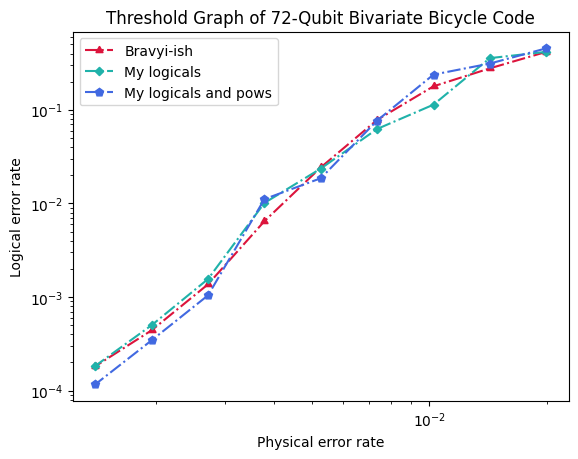

In [12]:
plt.plot(physical_error, 10/(2*np.array(results)), '-.', label='Bravyi-ish', color='crimson', marker=(3, 0, 0))
plt.plot(physical_error, 10/(2*np.array(results_log)), '-.', label='My logicals', color='lightseagreen', marker=(4, 0, 0))
plt.plot(physical_error, 10/(2*np.array(results_log_pow)), '-.', label='My logicals and pows', color='royalblue', marker=(5, 0, 0))
# plt.plot(physical_error, 10/(2*np.array(results)), '-.', color='darkorchid', marker=(6, 0, 0))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.legend()
plt.title('Threshold Graph of 72-Qubit Bivariate Bicycle Code');


## Compare decoding matrices

In [ ]:
with open('./deco', 'rb') as fp:
	mats = pickle.load(fp)


In [ ]:
with open('./deco_tog', 'rb') as fp:
	mats_tog = pickle.load(fp)


In [ ]:
print(f'3x3 toric separated {mats['3'][0].shape, mats['3'][1].shape}')
print(f'5x5 toric separated {mats['5'][0].shape, mats['5'][1].shape}')
print(f'7x7 toric separated {mats['7'][0].shape, mats['7'][1].shape}')


3x3 toric separated ((47, 190), (45, 190))
5x5 toric separated ((177, 826), (175, 826))
7x7 toric separated ((443, 2206), (441, 2206))


In [ ]:
print(f'3x3 toric together {mats_tog['3'][0].shape, mats_tog['3'][1].shape}')
print(f'5x5 toric together {mats_tog['5'][0].shape, mats_tog['5'][1].shape}')
print(f'7x7 toric together {mats_tog['7'][0].shape, mats_tog['7'][1].shape}')


3x3 toric together ((47, 181), (45, 181))
5x5 toric together ((177, 801), (175, 801))
7x7 toric together ((443, 2157), (441, 2157))


In [ ]:
d = 7
field = Field(2)
x, y = Monomial(field, 'x'), Monomial(field, 'y')
a, b = 1 - x, 1 - y

bb = BivariateBicycle(a, b, d, d, 1)
hx, hz = bb.hx, bb.hz
lx, lz = bb.x_logicals, bb.z_logicals

x_order = ['idle', 0, 3, 1, 2]
z_order = [0, 3, 1, 2, 'idle']
num_cycles = d

circ = construct_sm_circuit(bb, x_order, z_order)


In [27]:
# Using ldpc package

print('Setting up simulation...')
r, s = 0.8, 0.02
physical_error = np.array([s*(r**q) for q in range(10)])
results_sep, results_tog = [], []
error_rates = {'Meas': s, 'Prep': s, 'idle': s, 'CNOT': s}
hx_eff_sep, short_hx_eff_sep, hz_eff_sep, short_hz_eff_sep, s_channel_prob_x_sep, s_channel_prob_z_sep = mats[f'{d}']
hx_eff_tog, short_hx_eff_tog, hz_eff_tog, short_hz_eff_tog, s_channel_prob_x_tog, s_channel_prob_z_tog = mats_tog[f'{d}']

print(f'Starting full trials over physical error rates {physical_error}')

for i, p in enumerate(physical_error):
    error_rates = {'Meas': p, 'Prep': p, 'idle': p, 'CNOT': p}
    fails_sep = 0
    fails_tog = 0
    trials_sep = 0
    trials_tog = 0

    if i == 9:
        fails_sep += 10
        fails_tog += 10

    # Generate sm circuit and decoding matrix
    channel_prob_x_sep, channel_prob_z_sep = list((r**i)*np.array(s_channel_prob_x_sep)), list((r**i)*np.array(s_channel_prob_z_sep))
    channel_prob_x_tog, channel_prob_z_tog = list((r**i)*np.array(s_channel_prob_x_tog)), list((r**i)*np.array(s_channel_prob_z_tog))

    while fails_sep < 20 or fails_tog < 20:
        # Generate noisy circ
        noisy_circ, err_cnt = generate_noisy_circuit(bb, circ * num_cycles, error_rates)
        
        # Simulate noisy circ
        x_syndrome_history, x_state, x_syndrome_map, x_err_count = simulate_x_circuit(bb, noisy_circ + circ + circ)

        # Calculate true logical effect
        qudits_dict = bb.qudits_dict
        data_qudits = bb.data_qudits
        x_state_data_qudits = [x_state[qudits_dict[qudit]] for qudit in data_qudits]
        x_syndrome_final_logical = (np.array(lz) @ x_state_data_qudits) % field.p
        
        # Syndrome sparsification
        z_checks = bb.Zchecks
        x_syndrome_history_copy = x_syndrome_history.copy()
        for check in z_checks:
            pos = x_syndrome_map[check]
            assert len(pos) == num_cycles + 2
            for row in range(1, num_cycles + 2):
                x_syndrome_history[pos[row]] += x_syndrome_history_copy[pos[row-1]]
        x_syndrome_history %= field.p
        
        if fails_sep < 20:
            trials_sep += 1
            # Decode
            bposd = BpOsdDecoder(short_hx_eff_sep, error_channel=channel_prob_x_sep, max_iter=1000)
            x_error = bposd.decode(x_syndrome_history)
            assert np.all((short_hx_eff_sep @ x_error) % field.p == x_syndrome_history)
            
            # Check logical effect
            first_logical_row = bb.l * bb.m * (num_cycles + 2)
            k = len(lx)
            x_syndrome_history_augmented_guessed = (hx_eff_sep @ x_error) % field.p
            x_syndrome_final_logical_guessed = x_syndrome_history_augmented_guessed[first_logical_row: first_logical_row + k]
            
            if not np.array_equal(x_syndrome_final_logical_guessed, x_syndrome_final_logical):
                fails_sep += 1
                print(f'[SEPARATED] Physical error rate: {p:.4f}, Trial: {trials_sep}, Failures: {fails_sep}')

        if fails_tog < 20:
            trials_tog += 1
            # Decode
            bposd = BpOsdDecoder(short_hx_eff_tog, error_channel=channel_prob_x_tog, max_iter=1000)
            x_error = bposd.decode(x_syndrome_history)
            assert np.all((short_hx_eff_tog @ x_error) % field.p == x_syndrome_history)
            
            # Check logical effect
            first_logical_row = bb.l * bb.m * (num_cycles + 2)
            k = len(lx)
            x_syndrome_history_augmented_guessed = (hx_eff_tog @ x_error) % field.p
            x_syndrome_final_logical_guessed = x_syndrome_history_augmented_guessed[first_logical_row: first_logical_row + k]
            
            if not np.array_equal(x_syndrome_final_logical_guessed, x_syndrome_final_logical):
                fails_tog += 1
                print(f'[TOGETHER] Physical error rate: {p:.4f}, Trial: {trials_tog}, Failures: {fails_tog}')
    print('--------------------------------------------------------------')
    results_sep.append(trials_sep)
    results_tog.append(trials_tog)


Setting up simulation...
Starting full trials over physical error rates [0.02       0.016      0.0128     0.01024    0.008192   0.0065536
 0.00524288 0.0041943  0.00335544 0.00268435]
[SEPARATED] Physical error rate: 0.0200, Trial: 2, Failures: 1
[SEPARATED] Physical error rate: 0.0200, Trial: 3, Failures: 2
[TOGETHER] Physical error rate: 0.0200, Trial: 3, Failures: 1
[SEPARATED] Physical error rate: 0.0200, Trial: 4, Failures: 3
[TOGETHER] Physical error rate: 0.0200, Trial: 4, Failures: 2
[TOGETHER] Physical error rate: 0.0200, Trial: 5, Failures: 3
[SEPARATED] Physical error rate: 0.0200, Trial: 6, Failures: 4
[TOGETHER] Physical error rate: 0.0200, Trial: 6, Failures: 4
[SEPARATED] Physical error rate: 0.0200, Trial: 7, Failures: 5
[TOGETHER] Physical error rate: 0.0200, Trial: 7, Failures: 5
[SEPARATED] Physical error rate: 0.0200, Trial: 8, Failures: 6
[SEPARATED] Physical error rate: 0.0200, Trial: 9, Failures: 7
[TOGETHER] Physical error rate: 0.0200, Trial: 9, Failures: 6
[SE

KeyboardInterrupt: 

In [ ]:
results_sep


[26, 35, 44, 64, 143, 446, 945, 2952, 7595]

In [ ]:
results_tog


[26, 42, 41, 60, 148, 415, 1247, 2952, 6537]

In [2]:
ldpc_res_sep = {}
ldpc_res_sep[3] = [44, 65, 93, 150, 227, 258, 388, 671, 780, 1957]
ldpc_res_sep[5] = [24, 43, 44, 107, 201, 336, 757, 1407, 5032, 6784]
ldpc_res_sep[7] = [26, 35, 44, 64, 143, 446, 945, 2952, 7595]


In [3]:
ldpc_res = {}
ldpc_res[3] = [46, 65, 93, 167, 232, 258, 436, 710, 780, 2265]
ldpc_res[5] = [26, 43, 38, 109, 155, 341, 793, 1209, 4294, 7249]
ldpc_res[7] = [26, 42, 41, 60, 148, 415, 1247, 2952, 6537]


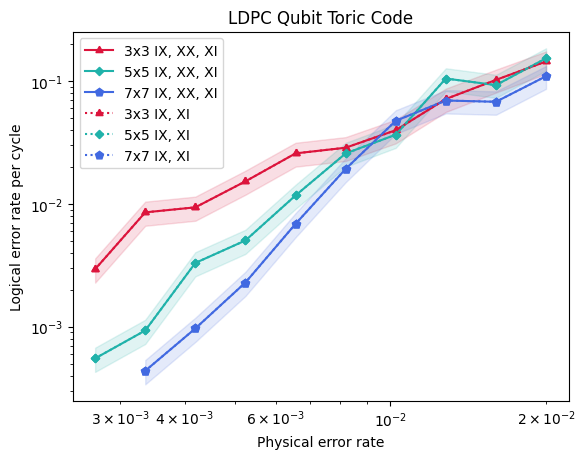

In [4]:
r, s = 0.8, 0.02
physical_error = np.array([s*(r**q) for q in range(10)])

plot_results, plot_errors = process_results(ldpc_res, {3:20, 5:20, 7:20}, "circuit_level", rounds={3:3, 5:5, 7:7})
plot_results_sep, plot_errors_sep = process_results(ldpc_res, {3:20, 5:20, 7:20}, "circuit_level", rounds={3:3, 5:5, 7:7})
alpha = 0.07

plt.plot(physical_error, plot_results[3], '-', label=f'3x3 IX, XX, XI', color='crimson', marker=(3, 0, 0))
plt.plot(physical_error, plot_results[5], '-', label=f'5x5 IX, XX, XI', color='lightseagreen', marker=(4, 0, 0))
plt.plot(physical_error[0:9], plot_results[7], '-', label=f'7x7 IX, XX, XI', color='royalblue', marker=(5, 0, 0))
plt.plot(physical_error, plot_results_sep[3], ':', label=f'3x3 IX, XI', color='crimson', marker=(3, 0, 0))
plt.plot(physical_error, plot_results_sep[5], ':', label=f'5x5 IX, XI', color='lightseagreen', marker=(4, 0, 0))
plt.plot(physical_error[0:9], plot_results_sep[7], ':', label=f'7x7 IX, XI', color='royalblue', marker=(5, 0, 0))

plt.fill_between(physical_error, plot_results[3] - plot_errors[3], plot_results[3] + plot_errors[3], color='crimson', alpha=alpha)
plt.fill_between(physical_error, plot_results[5] - plot_errors[5], plot_results[5] + plot_errors[5], color='lightseagreen', alpha=alpha)
plt.fill_between(physical_error[0:9], plot_results[7] - plot_errors[7], plot_results[7] + plot_errors[7], color='royalblue', alpha=alpha)
plt.fill_between(physical_error, plot_results_sep[3] - plot_errors_sep[3], plot_results_sep[3] + plot_errors_sep[3], color='crimson', alpha=alpha)
plt.fill_between(physical_error, plot_results_sep[5] - plot_errors_sep[5], plot_results_sep[5] + plot_errors_sep[5], color='lightseagreen', alpha=alpha)
plt.fill_between(physical_error[0:9], plot_results_sep[7] - plot_errors_sep[7], plot_results_sep[7] + plot_errors_sep[7], color='royalblue', alpha=alpha)

plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate per cycle')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title('LDPC Qubit Toric Code');


## Circuit-Level Threshold Let's Goooo!

In [2]:
d = 3
field = Field(2)
x, y = Monomial(field, 'x'), Monomial(field, 'y')
a, b = 1 - x, 1 - y

bb = BivariateBicycle(a, b, d, d, 1)
hx, hz = bb.hx, bb.hz
lx, lz = bb.x_logicals, bb.z_logicals

x_order = ['idle', 0, 3, 1, 2]
z_order = [0, 3, 1, 2, 'idle']

p = 0.01
num_cycles = d

circ = construct_sm_circuit(bb, x_order, z_order)


In [ ]:
# Using ldpc package
# np.random.seed(0)

print('Setting up simulation...')
r, s = 0.8, 0.02
physical_error = np.array([s*(r**q) for q in range(10)])
results = []
error_rates = {'Meas': s, 'Prep': s, 'idle': s, 'CNOT': s}
hx_eff, short_hx_eff, hz_eff, short_hz_eff, s_channel_prob_x, s_channel_prob_z = construct_decoding_matrix(bb, circ, error_rates, num_cycles)

print(f'Starting full trials over physical error rates {physical_error}')

for i, p in enumerate(physical_error):
    error_rates = {'Meas': p, 'Prep': p, 'idle': p, 'CNOT': p}
    fails = 0
    trials = 0

    # Generate sm circuit and decoding matrix
    channel_prob_x, channel_prob_z = list((r**i)*np.array(s_channel_prob_x)), list((r**i)*np.array(s_channel_prob_z))

    while fails < 20:
        trials += 1
        
        # Generate noisy circ
        noisy_circ, err_cnt = generate_noisy_circuit(bb, circ * num_cycles, error_rates)
        
        # Simulate noisy circ
        x_syndrome_history, x_state, x_syndrome_map, x_err_count = simulate_x_circuit(bb, noisy_circ + circ + circ)

        # Calculate true logical effect
        qudits_dict = bb.qudits_dict
        data_qudits = bb.data_qudits
        x_state_data_qudits = [x_state[qudits_dict[qudit]] for qudit in data_qudits]
        x_syndrome_final_logical = (np.array(lz) @ x_state_data_qudits) % field.p
        
        # Syndrome sparsification
        z_checks = bb.Zchecks
        x_syndrome_history_copy = x_syndrome_history.copy()
        for check in z_checks:
            pos = x_syndrome_map[check]
            assert len(pos) == num_cycles + 2
            for row in range(1, num_cycles + 2):
                x_syndrome_history[pos[row]] += x_syndrome_history_copy[pos[row-1]]
        x_syndrome_history %= field.p
        
        # Decode
        bposd = BpOsdDecoder(short_hx_eff, error_channel=channel_prob_x, max_iter=1000)
        x_error = bposd.decode(x_syndrome_history)
        assert np.all((short_hx_eff @ x_error) % field.p == x_syndrome_history)
        
        # Check logical effect
        first_logical_row = bb.l * bb.m * (num_cycles + 2)
        k = len(lx)
        x_syndrome_history_augmented_guessed = (hx_eff @ x_error) % field.p
        x_syndrome_final_logical_guessed = x_syndrome_history_augmented_guessed[first_logical_row: first_logical_row + k]
        
        if not np.array_equal(x_syndrome_final_logical_guessed, x_syndrome_final_logical):
            fails += 1
            print(f'Physical error rate: {p:.4f}, Trial: {trials}, Failures: {fails}')
    print('--------------------------------------------------------------')
    results.append(trials)


Setting up simulation...
Starting full trials over physical error rates [0.02       0.016      0.0128     0.01024    0.008192   0.0065536
 0.00524288 0.0041943  0.00335544 0.00268435]
Physical error rate: 0.0027, Trial: 51, Failures: 1
Physical error rate: 0.0027, Trial: 444, Failures: 2
Physical error rate: 0.0027, Trial: 1971, Failures: 3
Physical error rate: 0.0027, Trial: 4380, Failures: 4
Physical error rate: 0.0027, Trial: 4823, Failures: 5
Physical error rate: 0.0027, Trial: 7956, Failures: 6
--------------------------------------------------------------


In [9]:
results


[31, 33, 40, 62, 164, 346, 851, 6049, 9984, 37299]

In [24]:
# Using bbq package
# np.random.seed(0)

print('Setting up simulation...')
r, s = 0.8, 0.02
physical_error = np.array([s*(r**q) for q in range(10)])
results = []
error_rates = {'Meas': s, 'Prep': s, 'idle': s, 'CNOT': s}
hx_eff, short_hx_eff, hz_eff, short_hz_eff, s_channel_prob_x, s_channel_prob_z = construct_decoding_matrix(bb, circ, error_rates, num_cycles)

print(f'Starting full trials over physical error rates {physical_error}')

for num, p in enumerate(physical_error):
    error_rates = {'Meas': p, 'Prep': p, 'idle': p, 'CNOT': p}
    fails = 0
    trials = 0

    # Generate sm circuit and decoding matrix
    channel_prob_x, channel_prob_z = list((r**num)*np.array(s_channel_prob_x)), list((r**num)*np.array(s_channel_prob_z))
    x_prior = np.zeros((short_hx_eff.shape[1], field.p), dtype=float)
    for i, prob in enumerate(channel_prob_x):
        x_prior[i, 0] = 1 - prob
        for j in range(1, field.p):
            x_prior[i, j] = prob / (field.p - 1)

    bposd = BPOSD(field, short_hx_eff.toarray(), x_prior, max_iter=300, order=0)

    while fails < 10:
        trials += 1
        
        # Generate noisy circ
        noisy_circ, err_cnt = generate_noisy_circuit(bb, circ * num_cycles, error_rates)
        
        # Simulate noisy circ
        x_syndrome_history, x_state, x_syndrome_map, x_err_count = simulate_x_circuit(bb, noisy_circ + circ + circ)

        # Calculate true logical effect
        qudits_dict = bb.qudits_dict
        data_qudits = bb.data_qudits
        x_state_data_qudits = [x_state[qudits_dict[qudit]] for qudit in data_qudits]
        x_syndrome_final_logical = (np.array(lz) @ x_state_data_qudits) % field.p
        
        # Syndrome sparsification
        z_checks = bb.Zchecks
        x_syndrome_history_copy = x_syndrome_history.copy()
        for check in z_checks:
            pos = x_syndrome_map[check]
            assert len(pos) == num_cycles + 2
            for row in range(1, num_cycles + 2):
                x_syndrome_history[pos[row]] += x_syndrome_history_copy[pos[row-1]]
        x_syndrome_history %= field.p
        
        # Decode
        x_error, _ = bposd.decode(x_syndrome_history)
        assert np.all((short_hx_eff @ x_error) % field.p == x_syndrome_history)
        
        # Check logical effect
        first_logical_row = bb.l * bb.m * (num_cycles + 2)
        k = len(lx)
        x_syndrome_history_augmented_guessed = (hx_eff @ x_error) % field.p
        x_syndrome_final_logical_guessed = x_syndrome_history_augmented_guessed[first_logical_row: first_logical_row + k]
        
        if not np.array_equal(x_syndrome_final_logical_guessed, x_syndrome_final_logical):
            fails += 1
            print(f'Physical error rate: {p:.4f}, Trial: {trials}, Failures: {fails}')
        
        if trials % 25 == 0:
            print(f'UPDATE: For p = {p:.4f}, reached {trials} trials...')
    print('--------------------------------------------------------------')
    results.append(trials)


Setting up simulation...
Starting full trials over physical error rates [0.02       0.016      0.0128     0.01024    0.008192   0.0065536
 0.00524288 0.0041943  0.00335544 0.00268435]
Physical error rate: 0.0200, Trial: 1, Failures: 1
Physical error rate: 0.0200, Trial: 2, Failures: 2
Physical error rate: 0.0200, Trial: 3, Failures: 3
Physical error rate: 0.0200, Trial: 4, Failures: 4
Physical error rate: 0.0200, Trial: 5, Failures: 5
Physical error rate: 0.0200, Trial: 6, Failures: 6
Physical error rate: 0.0200, Trial: 7, Failures: 7
Physical error rate: 0.0200, Trial: 8, Failures: 8
Physical error rate: 0.0200, Trial: 9, Failures: 9
Physical error rate: 0.0200, Trial: 10, Failures: 10
--------------------------------------------------------------
Physical error rate: 0.0160, Trial: 1, Failures: 1
Physical error rate: 0.0160, Trial: 2, Failures: 2
Physical error rate: 0.0160, Trial: 3, Failures: 3
Physical error rate: 0.0160, Trial: 4, Failures: 4
Physical error rate: 0.0160, Trial: 6

In [ ]:
results


[10, 17, 14, 16, 15, 32, 28, 32, 31, 55]

In [ ]:
results


[22, 31, 58, 49, 98, 173, 158, 365, 618, 1040]

In [ ]:
trit_res = {}
trit_res[3] = [11, 16, 14, 17, 16, 20, 25, 30, 34, 41]


In [ ]:
my_res = {}
my_res[3] = [26, 21, 35, 64, 80, 203, 172, 462, 569, 1540]
my_res[5] = [13, 21, 24, 52, 39, 218, 431, 804, 1238, 4218]
my_res[7] = [14, 12, 17, 32, 78, 125, 221, 610, 582, 5168]


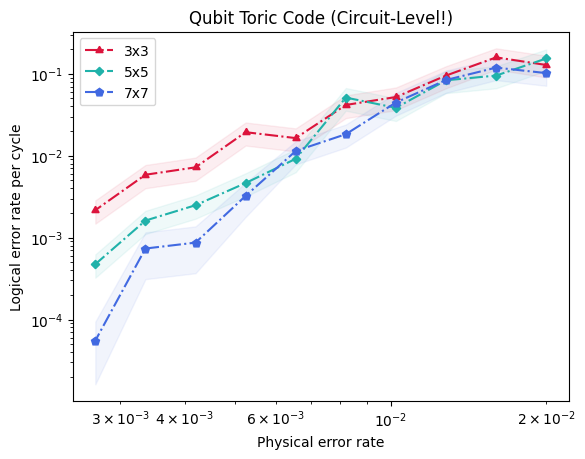

In [50]:
r, s = 0.8, 0.02
physical_error = np.array([s*(r**q) for q in range(10)])

plot_results, plot_errors = process_results(my_res, {3:10, 5:10, 7:[10, 10, 10, 10, 10, 10, 5, 3, 3, 2]}, "circuit_level", rounds={3:3, 5:5, 7:7})
alpha = 0.07

plt.plot(physical_error, plot_results[3], '-.', label=f'3x3', color='crimson', marker=(3, 0, 0))
plt.plot(physical_error, plot_results[5], '-.', label=f'5x5', color='lightseagreen', marker=(4, 0, 0))
plt.plot(physical_error, plot_results[7], '-.', label=f'7x7', color='royalblue', marker=(5, 0, 0))
plt.fill_between(physical_error, plot_results[3] - plot_errors[3], plot_results[3] + plot_errors[3], color='crimson', alpha=alpha)
plt.fill_between(physical_error, plot_results[5] - plot_errors[5], plot_results[5] + plot_errors[5], color='lightseagreen', alpha=alpha)
plt.fill_between(physical_error, plot_results[7] - plot_errors[7], plot_results[7] + plot_errors[7], color='royalblue', alpha=alpha)

plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate per cycle')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title('Qubit Toric Code (Circuit-Level!)');


In [6]:
ldpc_res = {}
ldpc_res[3] = [103, 165, 273, 277, 485, 787, 1117, 2015, 3195, 5960]
ldpc_res[5] = [66, 83, 151, 236, 352, 744, 1930, 4018, 10381, 20348]
ldpc_res[7] = [31, 33, 40, 62, 164, 346, 851, 6049, 9984, 37299]


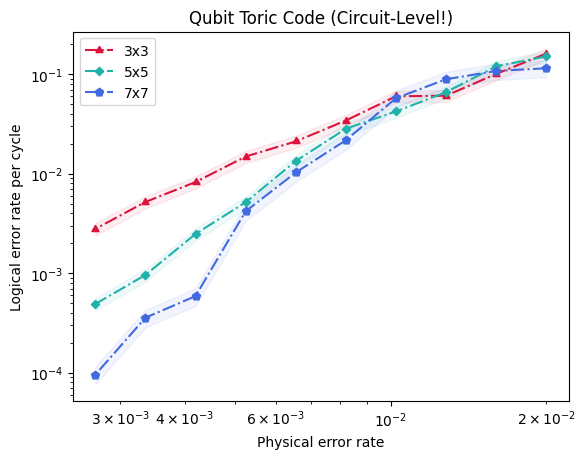

In [ ]:
r, s = 0.8, 0.02
physical_error = np.array([s*(r**q) for q in range(10)])

plot_results, plot_errors = process_results(ldpc_res, {3:50, 5:50, 7:25}, "circuit_level", rounds={3:3, 5:5, 7:7})
alpha = 0.07

plt.plot(physical_error, plot_results[3], '-.', label=f'3x3', color='crimson', marker=(3, 0, 0))
plt.plot(physical_error, plot_results[5], '-.', label=f'5x5', color='lightseagreen', marker=(4, 0, 0))
plt.plot(physical_error, plot_results[7], '-.', label=f'7x7', color='royalblue', marker=(5, 0, 0))
plt.fill_between(physical_error, plot_results[3] - plot_errors[3], plot_results[3] + plot_errors[3], color='crimson', alpha=alpha)
plt.fill_between(physical_error, plot_results[5] - plot_errors[5], plot_results[5] + plot_errors[5], color='lightseagreen', alpha=alpha)
plt.fill_between(physical_error, plot_results[7] - plot_errors[7], plot_results[7] + plot_errors[7], color='royalblue', alpha=alpha)

plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate per cycle')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title('Qubit Toric Code (Circuit-Level!)');


## Why does my decoder not like circuit-level?

NB: you only have to construct decoding matrix and channel prob once and then changing p can be done by multiplying! It's alll linear :)

In [2]:
d = 3
field = Field(2)
x, y = Monomial(field, 'x'), Monomial(field, 'y')
a, b = 1 - x, 1 - y

bb = BivariateBicycle(a, b, d, d, 1)
hx, hz = bb.hx, bb.hz
lx, lz = bb.x_logicals, bb.z_logicals

x_order = ['idle', 0, 3, 1, 2]
z_order = [0, 3, 1, 2, 'idle']

num_cycles = d
circ = construct_sm_circuit(bb, x_order, z_order)


In [3]:
# Set up
p = 0.004

error_rates = {'Meas': p, 'Prep': p, 'idle': p, 'CNOT': p}
fails = 0

# Generate sm circuit and decoding matrix
hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z = construct_decoding_matrix(bb, circ, error_rates, num_cycles)
x_prior = np.zeros((short_hx_eff.shape[1], field.p), dtype=float)
for i, prob in enumerate(channel_prob_x):
    x_prior[i, 0] = 1 - prob
    for j in range(1, field.p):
        x_prior[i, j] = prob / (field.p - 1)


In [4]:
# Generate noisy circ
noisy_circ, err_cnt = generate_noisy_circuit(bb, circ * num_cycles, error_rates)

# Simulate noisy circ
x_syndrome_history, x_state, x_syndrome_map, x_err_count = simulate_x_circuit(bb, noisy_circ + circ + circ)

# Calculate true logical effect
qudits_dict = bb.qudits_dict
data_qudits = bb.data_qudits
x_state_data_qudits = [x_state[qudits_dict[qudit]] for qudit in data_qudits]
x_syndrome_final_logical = (np.array(lz) @ x_state_data_qudits) % field.p

# Syndrome sparsification
z_checks = bb.Zchecks
x_syndrome_history_copy = x_syndrome_history.copy()
for check in z_checks:
    pos = x_syndrome_map[check]
    assert len(pos) == num_cycles + 2
    for row in range(1, num_cycles + 2):
        x_syndrome_history[pos[row]] += x_syndrome_history_copy[pos[row-1]]
x_syndrome_history %= field.p


In [5]:
# Decode with ldpc
ldpc_bposd = BpOsdDecoder(short_hx_eff, error_channel=channel_prob_x, max_iter=1000)

x_error = ldpc_bposd.decode(x_syndrome_history)
assert np.all((short_hx_eff @ x_error) % field.p == x_syndrome_history)

# Check logical effect
first_logical_row = bb.l * bb.m * (num_cycles + 2)
k = len(lx)
x_syndrome_history_augmented_guessed = (hx_eff @ x_error) % field.p
x_syndrome_final_logical_guessed = x_syndrome_history_augmented_guessed[first_logical_row: first_logical_row + k]

if not np.array_equal(x_syndrome_final_logical_guessed, x_syndrome_final_logical):
    ldpc_success = False
else:
    ldpc_success = True

print(ldpc_success)


True


In [6]:
x_syndrome_history = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])
x_error = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
x_syndrome_final_logical = np.array([0, 0])


In [6]:
# Decode with bbq
bbq_bposd = BPOSD(field, short_hx_eff.toarray(), x_prior, max_iter=1, order=0)
bbq_bp = BP(field, short_hx_eff.toarray(), x_prior, max_iter=1000)

x_error, _, _, posteriors = bbq_bp.decode(x_syndrome_history, debug=True)
# assert np.all((short_hx_eff @ x_error) % field.p == x_syndrome_history)

# Check logical effect
first_logical_row = bb.l * bb.m * (num_cycles + 2)
k = len(lx)
x_syndrome_history_augmented_guessed = (hx_eff @ x_error) % field.p
x_syndrome_final_logical_guessed = x_syndrome_history_augmented_guessed[first_logical_row: first_logical_row + k]

if not np.array_equal(x_syndrome_final_logical_guessed, x_syndrome_final_logical):
    bbq_success = False
else:
    bbq_success = True

print(bbq_success and np.all((short_hx_eff @ x_error) % field.p == x_syndrome_history))


True


/Users/eleanorkneip/Documents/phd/bbq-project/bbqudit/bbq/decoder.py:286: RuntimeWarning: divide by zero encountered in divide
  posteriors /= (


In [ ]:
np.exp(ldpc_bposd.log_prob_ratios)


In [ ]:
np.all(np.isclose(np.exp(ldpc_bposd.log_prob_ratios), posteriors[:, 0]))


np.True_

In [29]:
# Compare ldpc and bbq package
p = 0.04
print(f'Starting full trials over physical error rates {p}')

ldpc_success = True
bbq_success = True

error_rates = {'Meas': p, 'Prep': p, 'idle': p, 'CNOT': p}
fails = 0
trials = 0

# Generate sm circuit and decoding matrix
hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z = construct_decoding_matrix(bb, circ, error_rates, num_cycles)
x_prior = np.zeros((short_hx_eff.shape[1], field.p), dtype=float)
for i, prob in enumerate(channel_prob_x):
    x_prior[i, 0] = 1 - prob
    for j in range(1, field.p):
        x_prior[i, j] = prob / (field.p - 1)

ldpc_bposd = BpOsdDecoder(short_hx_eff, error_channel=channel_prob_x, max_iter=100)
bbq_bposd = BPOSD(field, short_hx_eff.toarray(), x_prior, max_iter=100, order=0)

while ldpc_success == bbq_success and trials < 100:
    trials += 1
    
    # Generate noisy circ
    noisy_circ, err_cnt = generate_noisy_circuit(bb, circ * num_cycles, error_rates)
    
    # Simulate noisy circ
    x_syndrome_history, x_state, x_syndrome_map, x_err_count = simulate_x_circuit(bb, noisy_circ + circ + circ)

    # Calculate true logical effect
    qudits_dict = bb.qudits_dict
    data_qudits = bb.data_qudits
    x_state_data_qudits = [x_state[qudits_dict[qudit]] for qudit in data_qudits]
    x_syndrome_final_logical = (np.array(lz) @ x_state_data_qudits) % field.p
    
    # Syndrome sparsification
    z_checks = bb.Zchecks
    x_syndrome_history_copy = x_syndrome_history.copy()
    for check in z_checks:
        pos = x_syndrome_map[check]
        assert len(pos) == num_cycles + 2
        for row in range(1, num_cycles + 2):
            x_syndrome_history[pos[row]] += x_syndrome_history_copy[pos[row-1]]
    x_syndrome_history %= field.p
    
    # Decode with ldpc
    x_error = ldpc_bposd.decode(x_syndrome_history)
    assert np.all((short_hx_eff @ x_error) % field.p == x_syndrome_history)
    
    # Check logical effect
    first_logical_row = bb.l * bb.m * (num_cycles + 2)
    k = len(lx)
    x_syndrome_history_augmented_guessed = (hx_eff @ x_error) % field.p
    x_syndrome_final_logical_guessed = x_syndrome_history_augmented_guessed[first_logical_row: first_logical_row + k]
    
    if not np.array_equal(x_syndrome_final_logical_guessed, x_syndrome_final_logical):
        ldpc_success = False
    else:
        ldpc_success = True

    # Decode with bbq
    x_error, _ = bbq_bposd.decode(x_syndrome_history)
    assert np.all((short_hx_eff @ x_error) % field.p == x_syndrome_history)
    
    # Check logical effect
    first_logical_row = bb.l * bb.m * (num_cycles + 2)
    k = len(lx)
    x_syndrome_history_augmented_guessed = (hx_eff @ x_error) % field.p
    x_syndrome_final_logical_guessed = x_syndrome_history_augmented_guessed[first_logical_row: first_logical_row + k]
    
    if not np.array_equal(x_syndrome_final_logical_guessed, x_syndrome_final_logical):
        bbq_success = False
    else:
        bbq_success = True

    trials += 1
    if trials % 5 == 0:
        print(f'Trials at {trials}!')


Starting full trials over physical error rates 0.04


/Users/eleanorkneip/Documents/phd/bbq-project/bbqudit/bbq/decoder.py:286: RuntimeWarning: divide by zero encountered in divide
  posteriors /= (


Trials at 10!
Trials at 20!
Trials at 30!
Trials at 40!
Trials at 50!
Trials at 60!
Trials at 70!
Trials at 80!
Trials at 90!
Trials at 100!


In [21]:
trials, err_cnt


(100, 19)

In [30]:
ldpc_bposd = BpOsdDecoder(short_hx_eff, error_channel=channel_prob_x, max_iter=100)
x_error = ldpc_bposd.decode(x_syndrome_history)
print(x_error)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0]


In [31]:
bbq_bposd = BPOSD(field, short_hx_eff.toarray(), x_prior, max_iter=100, order=0)
x_error, _, _, post = bbq_bposd.decode(x_syndrome_history, debug = True)
print(x_error)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0]


In [ ]:
np.all(np.isclose(np.exp(ldpc_bposd.log_prob_ratios), post[:, 0]))


np.True_

In [26]:
np.exp(ldpc_bposd.log_prob_ratios)


array([5.73811863e+00, 9.03767145e+01, 9.27500000e+01, 5.49069338e+01,
       1.36250137e+00, 9.27500000e+01, 5.49069338e+01, 3.92029505e+01,
       1.35157973e+03, 5.49069338e+01, 3.92029505e+01, 1.35157973e+03,
       5.49069338e+01, 3.92029505e+01, 1.35157973e+03, 1.19650446e+02,
       9.03767145e+01, 1.35157973e+03, 5.49069338e+01, 1.36250137e+00,
       9.27500000e+01, 1.19650446e+02, 9.03767145e+01, 1.35157973e+03,
       2.63319119e+00, 3.92029505e+01, 9.27500000e+01, 4.64235044e+02,
       2.57857143e+01, 4.64235044e+02, 2.57857143e+01, 4.64235044e+02,
       4.64235044e+02, 2.57857143e+01, 2.57857143e+01, 4.64235044e+02,
       7.36111111e-01, 1.05716826e+01, 8.65578864e+01, 8.65578864e+01,
       8.65578864e+01, 5.03086996e+00, 1.81889515e+02, 8.65578864e+01,
       1.81889515e+02, 8.65578864e+01, 4.58750000e+01, 4.58750000e+01,
       2.22035444e+01, 4.58750000e+01, 2.22035444e+01, 4.58750000e+01,
       2.22035444e+01, 4.58750000e+01, 4.58750000e+01, 1.07187500e+01,
      

In [27]:
post


array([[5.73811863e+00, 1.74273148e-01],
       [9.03767145e+01, 1.10647970e-02],
       [9.27500000e+01, 1.07816712e-02],
       [5.49069338e+01, 1.82126360e-02],
       [1.36250137e+00, 7.33944215e-01],
       [9.27500000e+01, 1.07816712e-02],
       [5.49069338e+01, 1.82126360e-02],
       [3.92029505e+01, 2.55082841e-02],
       [1.35157973e+03, 7.39874959e-04],
       [5.49069338e+01, 1.82126360e-02],
       [3.92029505e+01, 2.55082841e-02],
       [1.35157973e+03, 7.39874959e-04],
       [5.49069338e+01, 1.82126360e-02],
       [3.92029505e+01, 2.55082841e-02],
       [1.35157973e+03, 7.39874959e-04],
       [1.19650446e+02, 8.35767884e-03],
       [9.03767145e+01, 1.10647970e-02],
       [1.35157973e+03, 7.39874959e-04],
       [5.49069338e+01, 1.82126360e-02],
       [1.36250137e+00, 7.33944215e-01],
       [9.27500000e+01, 1.07816712e-02],
       [1.19650446e+02, 8.35767884e-03],
       [9.03767145e+01, 1.10647970e-02],
       [1.35157973e+03, 7.39874959e-04],
       [2.633191

oh noooo... all my posteriors are nan...

In [ ]:
x_error = ldpc_bposd.decode(x_syndrome_history)


In [ ]:
x_error


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
bbq_bposd = BPOSD(field, short_hx_eff.toarray(), x_prior, max_iter=1, order=0)


In [ ]:
test = np.array([[0.2, 0.7, 0.1], [0.3, 0.5, 0.2], [0.5, 0.3, 0.2], [0.5, 0.3, 0.2], [0, 1, 0]])
test


array([[0.2, 0.7, 0.1],
       [0.3, 0.5, 0.2],
       [0.5, 0.3, 0.2],
       [0.5, 0.3, 0.2],
       [0. , 1. , 0. ]])

In [ ]:
np.sum(test, axis=1)[:, np.newaxis]


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [ ]:
wh = (test!=0)
np.prod(test, axis=0, where=wh)


array([0.015 , 0.0315, 0.0008])

In [24]:
mask = np.ones_like(test, dtype=bool)
mask


array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [ ]:
final = np.empty_like(test)
for i in range(test.shape[0]):
    mask[i] = False
    final[i] = np.prod(test, axis=0, where=mask)
    mask[i] = True


In [ ]:
final


array([[0.    , 0.045 , 0.    ],
       [0.    , 0.063 , 0.    ],
       [0.    , 0.105 , 0.    ],
       [0.    , 0.105 , 0.    ],
       [0.015 , 0.0315, 0.0008]])